VERSION 1: INPUT AS (N,1) VECTOR

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
min_transactions = 200

N = 3 #number of pre-transactions used for predict

num_of_items = 57
time_slot = 24*60*60*1000 #1 day
time_slot

86400000

In [ ]:
RAWDATA_PATH = '/content/gdrive/MyDrive/NCKH/E-commerce/rawdata.csv'
HASH_FILE_PATH = '/content/gdrive/MyDrive/NCKH/E-commerce/hash_table.csv'
# NEW_DATA_PATH = '/content/gdrive/MyDrive/Timeseries/UserMoreThan200Trans.csv'
WEIGHTS_PATH = '/content/gdrive/MyDrive/NCKH/E-commerce/mlp_v1.hdf5'

In [ ]:
#load proceessed data
#ignore this cell in the first time you run!

df_hash = pd.read_csv(HASH_FILE_PATH)

temp = zip(df_hash.itemID,df_hash.hash_value)
hash_itemID = dict(temp)

temp = zip(df_hash.hash_value,df_hash.itemID)
reverse_hash_itemID = dict(temp)

# Prepare data

## Load data, convert to dataframe

In [ ]:
df = pd.read_csv(RAWDATA_PATH)
df.head()

,timestamp,userID,itemID
0,1604163797349,eed56d467112a57bbad058399b9c146410221,122
1,1604164215912,488f41e8995c2d6f5069eb46f723ee8710221,113
2,1604164499407,82e3bc40fbaf250d546b4e4de6bdb3aa10221,101
3,1604164521426,82e3bc40fbaf250d546b4e4de6bdb3aa10221,106
4,1604164654112,488f41e8995c2d6f5069eb46f723ee8710221,26


In [ ]:
hash_itemID = {}
idx = 0
for itemID in set(df.itemID):
  hash_itemID[itemID] = idx
  idx += 1

In [ ]:
time = df['timestamp'].values
itemIDs = df['itemID'].values
itemIDHash = []

for _ in itemIDs:
  itemIDHash.append(hash_itemID[_])


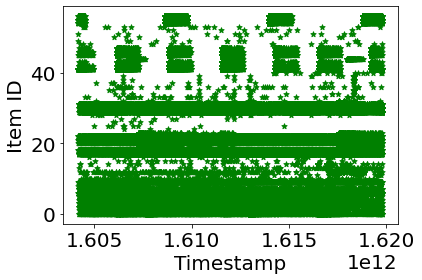

In [ ]:
plt.scatter(time, itemIDHash, label= "stars", color= "green",
            marker= "*", s=30)
plt.xlabel("Timestamp")
plt.ylabel("Item ID")
plt.show()

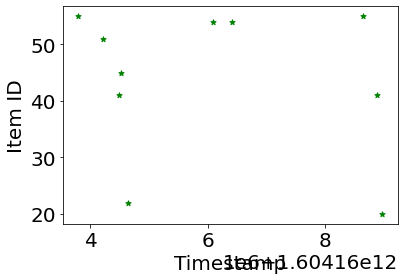

In [ ]:
plt.scatter(time[:10], itemIDHash[:10], label= "stars", color= "green",
            marker= "*", s=30)
plt.xlabel("Timestamp")
plt.ylabel("Item ID")
plt.show()

In [ ]:
lst_user = list(set(df.userID))

In [ ]:
df[df.userID == lst_user[0]].itemID[:10]

168     101
169       7
171      25
549      25
783      61
964      25
1401     25
1699     25
1915     25
2121      7
Name: itemID, dtype: int64

In [ ]:
subdf = df[df.userID == lst_user[0]]
item = list(map(lambda x: hash_itemID[x],subdf.itemID.tolist()))
subdf['timestamp'].values[:10], item[:10]

(array([1604202530776, 1604202644449, 1604202848502, 1604291011840,
        1604332021674, 1604374640765, 1604463021721, 1604548539982,
        1604633667666, 1604706813378]), [41, 6, 21, 21, 29, 21, 21, 21, 21, 6])

In [ ]:
time[:10], itemIDs[:10]

(array([1604163797349, 1604164215912, 1604164499407, 1604164521426,
        1604164654112, 1604166094500, 1604166405569, 1604168632245,
        1604168882200, 1604168966803]),
 array([122, 113, 101, 106,  26, 121, 121, 122, 101,  24]))

In [ ]:
with open(HASH_FILE_PATH,'w') as f:
  f.write('itemID,hash_value\n')
  for item in hash_itemID:
    f.write(f'{item},{hash_itemID[item]}\n')

In [ ]:
reverse_hash_itemID = {hash_itemID[i]:i for i in hash_itemID}

## Generate time series data

In [ ]:
import math

start_time = min(df.timestamp)
end_time = max(df.timestamp)
num_of_slots = math.ceil((end_time-start_time)/time_slot)
start_time,end_time,num_of_slots

(1604163797349, 1619801952751, 181)

### example

In [ ]:
userID = 'eed56d467112a57bbad058399b9c146410221'
subdf = df[df.userID == userID]
subdf

,timestamp,userID,itemID
0,1604163797349,eed56d467112a57bbad058399b9c146410221,122
40,1604180842140,eed56d467112a57bbad058399b9c146410221,101
689,1604319498998,eed56d467112a57bbad058399b9c146410221,5
716,1604324486866,eed56d467112a57bbad058399b9c146410221,122
852,1604361560049,eed56d467112a57bbad058399b9c146410221,122
...,...,...,...
83635,1619586629446,eed56d467112a57bbad058399b9c146410221,26
83636,1619586758395,eed56d467112a57bbad058399b9c146410221,106
83777,1619605764963,eed56d467112a57bbad058399b9c146410221,122
84582,1619747121675,eed56d467112a57bbad058399b9c146410221,63


In [ ]:
series = np.zeros((num_of_slots,num_of_items))
count = [0]*num_of_slots
lst_time = subdf.timestamp.tolist()
lst_itemID = subdf.itemID.tolist()
for time,itemID in zip(lst_time,lst_itemID):
  idx = (time-start_time) // time_slot
  series[idx][hash_itemID[itemID]] = 1
  count[idx] += 1

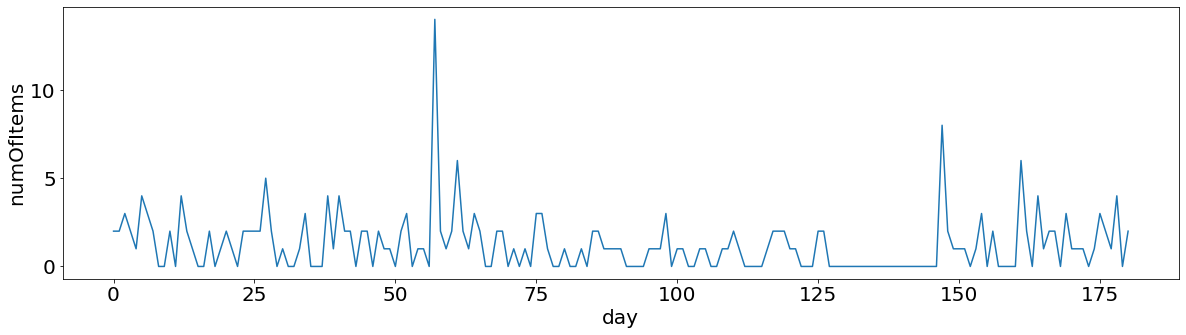

In [ ]:
plt.figure(figsize=(20,5))
plt.rc('font', size=20) 
plt.plot(range(len(count)),count)
plt.xlabel('day',fontsize=20)
plt.ylabel('numOfItems',fontsize=20)
plt.show()

In [ ]:
history = list(map(lambda x: hash_itemID[x],subdf.itemID.tolist()))
print(*history,sep=' ')

55 41 4 55 55 55 55 1 21 21 20 7 0 31 6 21 29 29 30 15 31 20 30 29 30 6 21 21 30 30 20 6 21 3 41 45 41 3 47 41 20 41 6 41 2 1 21 21 0 44 20 6 7 21 29 29 30 29 30 29 30 30 20 6 0 1 2 30 21 3 30 20 4 6 5 30 55 30 54 55 22 6 19 23 41 45 55 30 55 55 30 55 55 56 54 30 41 55 41 41 55 55 41 17 18 9 21 9 6 55 55 55 55 7 30 31 29 6 29 30 1 30 30 30 6 9 17 30 29 6 41 45 41 44 41 41 41 6 7 30 6 29 29 29 16 30 6 0 30 30 1 2 6 55 41 45 41 6 41 55 41 41 7 6 29 29 41 45 6 0 1 2 29 3 41 30 41 41 41 4 6 7 5 31 29 6 29 30 44 30 0 19 23 30 30 30 22 31 30 30 6 30 55 55 55 55 22 55 41 41 6 1 41 0 41 41 22 45 55 30 30


In [ ]:
import more_itertools as mit
X_idx = np.array(list(mit.windowed(history, n=N, step=1)))[:-1]
y = history[N:]

In [ ]:
X = []
for x in X_idx:
  new_record = [0]*num_of_items
  new_record[x[0]] = 1
  new_record[x[1]] = 1
  new_record[x[2]] = 1
  X.append(new_record)
X = np.array(X)

### generate

In [ ]:
lst_user = list(set(df.userID))
len(lst_user)

306

In [ ]:
import more_itertools as mit
from google.colab import output
X_idx = []
y = []

def onehot(x):
  #x: int
  lst = [0]*num_of_items
  lst[x] = 1
  return lst



for userID in lst_user:
  subdf = df[df.userID == userID]
  history = list(map(lambda x: hash_itemID[x],subdf.itemID.tolist()))
  X_idx.extend(list(mit.windowed(history, n=N, step=1))[:-1])
  y.extend(list(map(onehot,history[N:])))

X = np.array(X_idx)
y = np.array(y)

## split train-test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
X_train[0:5],y_train[0]

(array([[ 2,  3,  1],
        [31, 29, 29],
        [41, 41, 31],
        [21, 30, 30],
        [ 9, 29, 29]]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
print(X_train.shape)
print(y_train.shape)

(58788, 3)
(58788, 57)


# MLP

In [ ]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

model = Sequential()

model.add(Dense(128, input_shape=(N,), activation= 'relu'))

model.add(Dense(num_of_items, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               512       
                                                                 
 dense_5 (Dense)             (None, 57)                7353      
                                                                 
Total params: 7,865
Trainable params: 7,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=5, monitor='loss', restore_best_weights=True)
model.fit(X_train,y_train,batch_size=8,epochs=1000,verbose=True, callbacks=[early_stop, model_checkpoint])

Epoch 1/1000
7349/7349 [==============================] - 25s 3ms/step - loss: 2.9611 - accuracy: 0.1769
Epoch 2/1000
7349/7349 [==============================] - 24s 3ms/step - loss: 2.6381 - accuracy: 0.2509
Epoch 3/1000
7349/7349 [==============================] - 24s 3ms/step - loss: 2.5688 - accuracy: 0.2739
Epoch 4/1000
7349/7349 [==============================] - 24s 3ms/step - loss: 2.5207 - accuracy: 0.2874
Epoch 5/1000
7349/7349 [==============================] - 24s 3ms/step - loss: 2.4941 - accuracy: 0.2958
Epoch 6/1000
7349/7349 [==============================] - 24s 3ms/step - loss: 2.4788 - accuracy: 0.2999
Epoch 7/1000
7349/7349 [==============================] - 24s 3ms/step - loss: 2.4676 - accuracy: 0.3020
Epoch 8/1000
7349/7349 [==============================] - 24s 3ms/step - loss: 2.4593 - accuracy: 0.3055
Epoch 9/1000
7349/7349 [==============================] - 24s 3ms/step - loss: 2.4521 - accuracy: 0.3065
Epoch 10/1000
7349/7349 [==============================

In [ ]:
def post_process(x):
  idx = x.argsort()[-1:-6:-1]
  return list(zip(idx,x[idx]))

In [ ]:
y_preds = model.predict(X_test)

y_preds = np.array(list(map(post_process,y_preds)))
acc = 0
for y_true, y_pred in zip(y_test,y_preds):
  key = np.argmax(y_true)
  if key in y_pred: acc += 1

acc/len(y_test)

0.6997936180346087

In [ ]:
#wrapper
def process(x):
  #x: array/ndarray of N item

  inp = np.array(x)
  y_pred = model.predict(np.array([inp]))
  y_pred = post_process(y_pred[0])
  out = list(map(lambda t: (reverse_hash_itemID[t[0]],t[1]),y_pred))

  return out

## Infer

In [ ]:
process([101,106,7])

[(122, 0.9324983),
 (121, 0.032461304),
 (123, 0.026592562),
 (101, 0.007032847),
 (26, 0.0006742528)]